In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.mixture import GaussianMixture

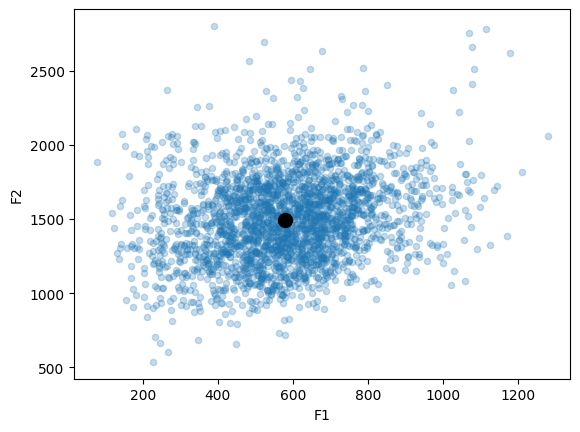

In [2]:
# フォルマント推定結果が保存された CSV ファイルを読み込む
# 各行は 1 フレーム（または 1 サンプル）に対応し，
# 少なくとも「Vowel」「F1」「F2」列を持つことを想定している
dfFormant = pd.read_csv("FormantCVTrainShort.csv")

# 母音が「あ」に相当するサンプルだけを抽出し（Vowel=="a"），
# 第1フォルマント F1 を x 軸，第2フォルマント F2 を y 軸として散布図を描く
# alpha=0.25 により点を半透明にして，サンプルの密度が視覚的に分かりやすくなっている
dfFormant.query('Vowel=="a"').plot.scatter(x="F1", y="F2", alpha=0.25)

# 同じく「あ」のサンプルに絞ったうえで，F1 と F2 の平均値（重心）を計算する
# [['F1','F2']] で F1,F2 の2列だけを取り出し，mean() で列ごとの平均値を計算
# to_numpy() で (F1_mean, F2_mean) という形の NumPy 配列に変換している
mean_F1_F2 = dfFormant.query('Vowel=="a"')[["F1", "F2"]].mean().to_numpy()

# 平均フォルマント位置（クラス「a」の代表点）を黒丸 ('ok') でプロットする
# *mean_F1_F2 により，(x, y) = (F1_mean, F2_mean) として渡される
# markersize=10 で周囲の散布点よりも大きく目立たせている
plt.plot(*mean_F1_F2, "ok", markersize=10)

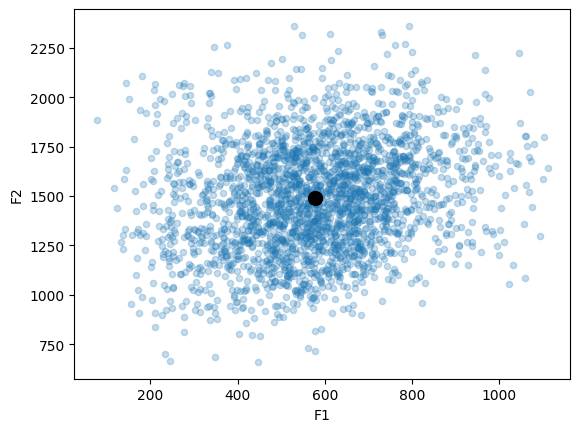

In [3]:
plt.close()

# 各母音クラスごとに F1, F2 の外れ値度合い（zスコア）を計算するためのループ
# dfFormant['Vowel'].unique() で，CSV に含まれるすべての母音ラベルを列挙する
for v in dfFormant["Vowel"].unique():
    # その母音 v に属する行インデックスだけを取り出す
    i = dfFormant.query(f'Vowel=="{v}"').index

    # 第1フォルマント F1 について，母音 v のサンプル内での z スコアを計算し，
    # その絶対値を zF1 列に格納する
    # → 各母音ごとに「平均から何標準偏差だけ離れているか」を測っている
    dfFormant.loc[i, "zF1"] = np.abs(stats.zscore(dfFormant.loc[i, "F1"]))

    # 第2フォルマント F2 についても同様に z スコアの絶対値を計算し，zF2 列に格納する
    dfFormant.loc[i, "zF2"] = np.abs(stats.zscore(dfFormant.loc[i, "F2"]))

# zF1, zF2 の両方が 3 未満（≒ 平均±3σ 以内）にある「あ」のサンプルだけを抽出
# → F1, F2 が極端に外れたフレームを除外することで，
#   クラス "a" のフォルマント分布をより「代表的な」サンプルに限定する
dfA = dfFormant.query('zF1 < 3 & zF2 < 3 & Vowel=="a"')

# 外れ値を除いた「あ」のサンプルに対して，F1–F2 平面上の散布図を描画
# alpha=0.25 で半透明にして，サンプル密度の高い領域が視覚的に分かりやすくなる
dfA.plot.scatter(x="F1", y="F2", alpha=0.25)

# 外れ値除去後の F1, F2 の平均値（クラス "a" の代表点）を計算して描画
# [['F1','F2']].mean().to_numpy() で (mean_F1, mean_F2) の形に変換し，
# plt.plot(*...) で (x, y) 座標として渡している
# 'ok' は黒丸マーカー，markersize=10 で散布点よりも目立つようにしている
plt.plot(*(dfA[["F1", "F2"]].mean().to_numpy()), "ok", markersize=10)

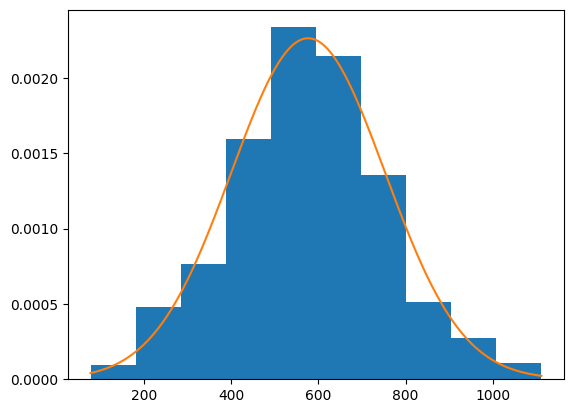

In [4]:
# 図をリセット（前のプロットをクリア）
plt.close()

# 外れ値を除去した /a/ の第1フォルマント F1 のヒストグラムを描画
# density=True とすることで、縦軸が「度数」ではなく「確率密度」になる
# （棒グラフの面積が 1 になるように正規化される）
plt.hist(dfA["F1"], density=True)

# （必要なら）縦軸の目盛りラベルを消すためのコマンド
# 今回は例としてコメントアウトされている
# plt.tick_params(labelleft=False)

# F1 の最小値〜最大値の範囲で、正規分布の理論曲線を描くための x 軸を作成
x = np.arange(dfA["F1"].min(), dfA["F1"].max())

# 外れ値除去後の F1 の「標本平均」と「標本標準偏差」を使って正規分布 N(μ, σ^2) を生成し、
# その確率密度関数 pdf(x) をヒストグラムの上に重ねて描画する
# これにより、観測された F1 分布が正規分布でどの程度近似できるかを視覚的に評価できる
plt.plot(
    x,
    stats.norm.pdf(
        x=x,
        loc=dfA["F1"].mean(),  # 正規分布の平均 μ に対応
        scale=dfA["F1"].std(),  # 正規分布の標準偏差 σ に対応
    ),
)

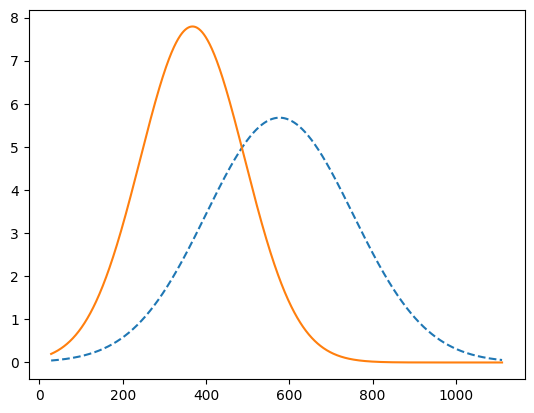

In [5]:
# 既存の図をクリアしてリセット
plt.close()

# /i/ 母音に対する外れ値除去済みデータフレームを作成
# ここでは、各母音ごとに計算しておいた zF1, zF2（Z スコア）を使い、
# zF1, zF2 がともに 3 未満（＝平均から 3σ 以内）のサンプルだけを残している
dfI = dfFormant.query('zF1 < 3 & zF2 < 3 & Vowel=="i"')

# 「どの範囲の F1 を x 軸とするか」という条件を文字列で定義
# a と i の両方を含む全体の F1 の範囲で、分布を比較したいので、
# Vowel 条件は付けず zF1, zF2 の条件だけにしている
conditionRange = "zF1 < 3 & zF2 < 3"

# 上で定めた条件を満たす全データ（全母音）の F1 の最小値〜最大値を x 軸として使用
# この範囲で /a/ と /i/ のガウス近似曲線を重ね描きする
xF1 = np.arange(
    dfFormant.query(conditionRange)["F1"].min(),
    dfFormant.query(conditionRange)["F1"].max(),
)

# /a/ の F1 分布を「正規分布で近似した理論曲線」として描く
# ・stats.norm.pdf で N(μ_a, σ_a^2) の確率密度関数を計算
# ・ヒストグラムの棒グラフとスケールを合わせるため、サンプル数 len(dfA) を掛けている
#   （確率密度 → 「度数」相当へのスケーリング）
plt.plot(
    xF1,
    len(dfA)
    * stats.norm.pdf(
        x=xF1,
        loc=dfA["F1"].mean(),  # /a/ の F1 の平均値 μ_a
        scale=dfA["F1"].std(),  # /a/ の F1 の標準偏差 σ_a
    ),
    "--",  # /a/ の曲線は破線で描画
)

# /i/ についても同様に、F1 の分布を正規分布で近似した曲線を描く
# こちらもサンプル数 len(dfI) を掛けることで、/a/ の曲線と「度数レベル」で比較できる
plt.plot(
    xF1,
    len(dfI)
    * stats.norm.pdf(
        x=xF1,
        loc=dfI["F1"].mean(),  # /i/ の F1 の平均値 μ_i
        scale=dfI["F1"].std(),  # /i/ の F1 の標準偏差 σ_i
    ),
)

# 現在の Figure オブジェクトを取得
fig = plt.gcf()

# 図を EPS 形式で保存
# ここでは、/a/ と /i/ の F1 分布をガウス近似した 2 本の曲線を比較する図として
# 'fig07_04.eps' に出力しており、論文・スライド用のベクタ画像として利用できる
fig.savefig("fig07_04.eps")

In [6]:
# 未知の母音サンプルから得られた F1 値（ここでは 300 Hz と仮定）
unknownF1 = 300

# -------------------------------
# /a/ クラスのガウスモデルにおける尤度
# -------------------------------
# dfA は Vowel=="a" かつ外れ値除去済みのサンプル集合
# その F1 の平均 μ_a, 標準偏差 σ_a を用いて
#   p(F1 = 300 | Vowel = "a") = N(300; μ_a, σ_a^2)
# を計算している
likeA = stats.norm.pdf(
    x=unknownF1,
    loc=dfA["F1"].mean(),  # /a/ の F1 平均 μ_a
    scale=dfA["F1"].std(),  # /a/ の F1 標準偏差 σ_a
)

# -------------------------------
# /i/ クラスのガウスモデルにおける尤度
# -------------------------------
# dfI は Vowel=="i" かつ外れ値除去済みのサンプル集合
# その F1 の平均 μ_i, 標準偏差 σ_i を用いて
#   p(F1 = 300 | Vowel = "i") = N(300; μ_i, σ_i^2)
# を計算している
likeI = stats.norm.pdf(
    x=unknownF1,
    loc=dfI["F1"].mean(),  # /i/ の F1 平均 μ_i
    scale=dfI["F1"].std(),  # /i/ の F1 標準偏差 σ_i
)

# likeA と likeI を比較することで、
#   - F1 = 300 Hz という観測値が /a/ と /i/ のどちらのクラスで「出やすい」か
# を評価できる（ガウス判別・ベイズ識別でいうクラス条件付き尤度）。
# ここでは最後に likeI を式として置いておくと、
# 対話環境や対話型インタプリタ上では likeI の数値が表示される想定。
likeI

np.float64(0.002752478539128988)

(660.137903207859, 2360.4414866306)

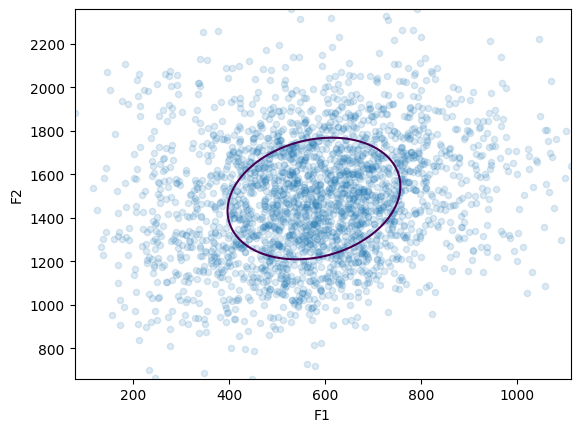

In [7]:
# 前の図をクリアしてリセット
plt.close()

# zスコアが |zF1|<3, |zF2|<3 の範囲に入るサンプルだけを対象とする条件式
# （平均±3σ 以内にあるデータ → 極端な外れ値を除去したクリーンなデータ群）
condRange = "zF1 < 3 & zF2 < 3"

# 条件を満たす /a/ 母音のデータフレーム
dfA = dfFormant.query(condRange + '& Vowel=="a"')

# 条件を満たす /i/ 母音のデータフレーム（このセルでは使っていないが、後続処理で利用する想定）
dfI = dfFormant.query(condRange + '& Vowel=="i"')

# 全体（全母音）のうち、外れ値除去済みサンプルの F1, F2 の範囲を取得し、
# その範囲でグリッド（xF1, xF2）を定義する
# → このグリッド上で 2次元ガウス分布の確率密度を評価して等高線を描く
xF1 = np.arange(
    dfFormant.query(condRange)["F1"].min(), dfFormant.query(condRange)["F1"].max()
)
xF2 = np.arange(
    dfFormant.query(condRange)["F2"].min(), dfFormant.query(condRange)["F2"].max()
)

# 2次元グリッド（F1-F2 平面）を作成
# x: 各格子点の F1 座標
# y: 各格子点の F2 座標
x, y = np.meshgrid(xF1, xF2)

# multivariate_normal.pdf に渡すために、(F1, F2) の並びを 3次元配列 pos にまとめる
# pos[i,j] = [x[i,j], y[i,j]] という形になる
pos = np.dstack((x, y))

# /a/ の観測データを F1-F2 平面に散布図として描画
# 透明度 alpha=0.15 にしているので、点が重なっている領域ほど濃く見える
dfA.plot.scatter(x="F1", y="F2", alpha=0.15)

# /a/ の F1-F2 の平均ベクトル μ = [μ_F1, μ_F2]
muA = dfA[["F1", "F2"]].mean()

# /a/ の F1-F2 共分散行列 Σ（2×2 行列）
# Σ = [[Var(F1), Cov(F1,F2)],
#      [Cov(F2,F1), Var(F2)]]
sigmaA = dfA[["F1", "F2"]].cov().to_numpy()

# 2次元ガウス分布 N(μ, Σ) の確率密度をグリッド pos 上で評価し、
# そのうち「ある一定値の等高線」を1本だけ描画する
# ここでは、
#   μ から F1 方向に +√Var(F1) だけ離れた点
#   [μ_F1 + √(Σ[0,0]), μ_F2]
# における確率密度値をレベルとして指定している。
# → 結果として、1σ 相当（目安）の楕円等高線が描かれる。
plt.contour(
    xF1,  # 等高線の x 軸（F1 軸）
    xF2,  # 等高線の y 軸（F2 軸）
    stats.multivariate_normal.pdf(pos, muA, sigmaA),  # グリッド上の pdf 値
    [
        stats.multivariate_normal.pdf(
            [
                muA.iloc[0] + np.sqrt(sigmaA[0, 0]),  # F1 方向に +1σ だけずらした点
                muA.iloc[1],
            ],  # F2 は平均値
            muA,
            sigmaA,
        )
    ],  # この1点における pdf を「等高線レベル」として指定
)

# x 軸・y 軸の表示範囲を /a/ の観測データの範囲に揃える
# → 分布の中心付近にフォーカスした図になる
plt.xlim(dfA["F1"].min(), dfA["F1"].max())
plt.ylim(dfA["F2"].min(), dfA["F2"].max())

In [8]:
def getLevel2DMVN(mu, sigma, nLevel):
    # 2次元多変量ガウス分布 N(mu, sigma) の等高線レベルを求める関数
    # mu   : 平均ベクトル（pandas.Series 想定, mu.iloc[0] が F1, mu.iloc[1] が F2）
    # sigma: 共分散行列（2×2 の numpy 配列）
    # nLevel: 何段階分のレベルを計算するか（0〜nLevel の合計 nLevel+1 個）
    #
    # ここでは、F1 軸方向に 0, 1σ, 2σ, ..., nσ だけ平均からずらした点
    #   [mu_F1 + n * sqrt(Var(F1)), mu_F2]
    # における確率密度 p(x) = N(x; mu, sigma) を計算し、
    # それらを contour のレベル値として使えるよう配列で返す。
    # → 「中心からどれだけ離れた楕円か」を nσ でパラメタライズした等高線レベル。

    # レベル値を格納する配列（0 〜 nLevel までの nLevel+1 個ぶん）
    level = np.zeros(nLevel + 1)

    # n = 0, 1, ..., nLevel について、それぞれの点での pdf を計算
    for n in np.arange(nLevel + 1):
        # F1 方向に n * sqrt(sigma[0,0]) だけ平均からずらした点 [F1, F2=平均] を作る
        point = [mu.iloc[0] + n * np.sqrt(sigma[0, 0]), mu.iloc[1]]

        # その点における多変量正規分布の確率密度を計算し、level[n] に格納
        level[n] = stats.multivariate_normal.pdf(point, mu, sigma)

    # 等高線描画などに使えるレベル値の配列を返す
    return level

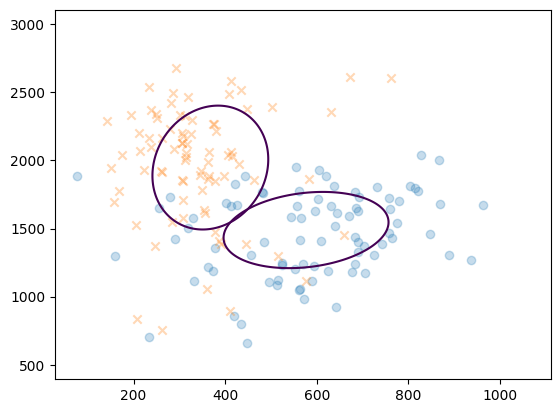

In [9]:
# 既存の図をクリアしてリセット
plt.close()

# Figure と Axes オブジェクトを作成
fig, ax = plt.subplots()

# /a/・/i/ の全データをそのまま描くと点が多すぎて見づらくなるので、
# それぞれ 1/30 だけランダムサンプリングして可視化用のサブセットを作る
dfASample = dfA.sample(frac=1 / 30)
dfISample = dfI.sample(frac=1 / 30)

# /a/ のサンプルを F1–F2 平面に散布図として描画
# ・丸マーカー
# ・alpha=0.25 で半透明 → 密度の高い領域ほど濃く見える
ax.scatter(dfASample["F1"], dfASample["F2"], alpha=0.25)

# /i/ のサンプルを F1–F2 平面に散布図として描画
# ・×マーカーで /a/ と区別
# ・alpha=0.3 でやや薄く描画
ax.scatter(dfISample["F1"], dfISample["F2"], marker="x", alpha=0.3)

# ----------------------------------------------------------
# /a/ の F1–F2 分布を「2次元ガウス分布 N(μ_a, Σ_a)」で近似し、
# その等高線（楕円）を描画
# ----------------------------------------------------------

# /a/ の平均ベクトル μ_a と共分散行列 Σ_a を用いて、
# グリッド pos 上の確率密度 p_a(x) = N(x; μ_a, Σ_a) を計算し、
# その値に対して contour（等高線）を描画する。
#
# 等高線レベルには getLevel2DMVN(...) で計算した pdf 値を使用している。
#  getLevel2DMVN は、
#   [μ_F1 + nσ_F1, μ_F2] (n=0,1,...) における pdf を返す関数で、
#  「中心から nσ 離れた楕円」のレベル値に対応する。
#  np.flip(...) で大きいレベルから小さいレベルの順に並べ、
#  内側（高密度）→外側（低密度）の順に楕円が描かれるようにしている。
plt.contour(
    xF1,  # F1 軸（x 軸）
    xF2,  # F2 軸（y 軸）
    stats.multivariate_normal.pdf(  # グリッド上の pdf 値（/a/ 用）
        pos, dfA[["F1", "F2"]].mean(), dfA[["F1", "F2"]].cov()  # μ_a  # Σ_a
    ),
    np.flip(  # 等高線レベルを「高→低」の順に並べ替え
        getLevel2DMVN(
            dfA[["F1", "F2"]].mean(),  # μ_a
            dfA[["F1", "F2"]].cov().to_numpy(),  # Σ_a（numpy 配列）
            1,  # nLevel=1 → 0σ,1σ の 2 レベルを返す
        )
    ),
)

# ----------------------------------------------------------
# /i/ の F1–F2 分布を「2次元ガウス分布 N(μ_i, Σ_i)」で近似し、
# その等高線（楕円）を描画
# ----------------------------------------------------------

# 上と同様に、/i/ に対しても N(μ_i, Σ_i) の pdf をグリッド pos 上で評価し、
# その等高線を描画する。
# こうすることで、
#   ・散布図 → 実際の観測分布
#   ・ガウス楕円 → モデル化されたクラス分布
# を同じ図上で比較できる。
plt.contour(
    xF1,
    xF2,
    stats.multivariate_normal.pdf(
        pos, dfI[["F1", "F2"]].mean(), dfI[["F1", "F2"]].cov()  # μ_i  # Σ_i
    ),
    np.flip(
        getLevel2DMVN(
            dfI[["F1", "F2"]].mean(),  # μ_i
            dfI[["F1", "F2"]].cov().to_numpy(),  # Σ_i
            1,
        )
    ),
)

# 現在アクティブな Figure を取得
fig = plt.gcf()

# 図を PDF 形式で保存
# fig07_06.pdf には、
#   ・/a/（丸）と /i/（×）のサンプル点
#   ・各クラスの 2次元ガウス近似の楕円等高線
# が描かれ、F1–F2 平面における「クラス分布」と「ガウスモデル」の対応が
# 一目で分かる図として出力される。
fig.savefig("fig07_06.pdf")

In [ ]:
plt.close()

# /i/ 母音の全サンプルから F1, F2 の 2 次元特徴だけを取り出す
dfIall = dfFormant.query('Vowel=="i"')[["F1", "F2"]]

# （1）GMM（ガウシアン混合モデル）を 1 成分でフィット
#     → 「/i/ の (F1, F2) 分布を 1 つの 2 次元ガウスで近似」
gmm1 = GaussianMixture(
    n_components=1,  # ガウス成分数 = 1
    covariance_type="diag",  # 共分散行列を対角行列と仮定（F1,F2 の相関は無視）
).fit(dfIall)

# （2）GMM を 2 成分でフィット
#     → 「/i/ 分布の多峰性（話者グループ差など）を 2 つのガウスで表現」
gmm2 = GaussianMixture(
    n_components=2, covariance_type="diag"  # ガウス成分数 = 2  # 同じく対角共分散
).fit(dfIall)

# メッシュグリッド pos (xF1 × xF2) を GMM の score_samples に渡せる形に 2 次元配列へ整形
# cord: 形状 (格子点数, 2) の [F1, F2] ベクトル列
cord = np.reshape(pos, (pos.shape[0] * pos.shape[1], 2))

# 1 行 2 列のサブプロット領域を作成（左: 1 成分 GMM, 右: 2 成分 GMM）
_, axes = plt.subplots(1, 2)

# 表示範囲を /i/ サンプルの最小〜最大に合わせておく
xRange = (dfI["F1"].min(), dfI["F1"].max())
yRange = (dfI["F2"].min(), dfI["F2"].max())

# -------------------------------
# 左図：1 成分 GMM による分布近似
# -------------------------------
# /i/ の全サンプル (F1,F2) を散布図として描画
dfIall.plot.scatter(x="F1", y="F2", alpha=0.1, ax=axes[0])

# 左側サブプロットを明示的にアクティブにする
plt.subplot(1, 2, 1)

# gmm1.score_samples(cord) は「各点での対数確率密度 log p(x)」を返す。
# これを pos と同じ形に戻して等高線として描くことで、
# 「1 つの 2 次元ガウス分布で近似したときの等確率線（楕円）」を可視化する。
plt.contour(
    xF1, xF2, np.reshape(gmm1.score_samples(cord), (pos.shape[0], pos.shape[1]))
)

# -------------------------------
# 右図：2 成分 GMM による分布近似
# -------------------------------
# 右側サブプロットにも /i/ の全サンプル散布図を描画
dfIall.plot.scatter(x="F1", y="F2", alpha=0.1, ax=axes[1])

# 右図では y 軸ラベルと目盛りを消して、左右図の比較をしやすくする
axes[1].set_ylabel("")
axes[1].set_yticks([])

# x, y の表示範囲を /i/ データの範囲に固定（左図と揃える）
plt.xlim(xRange)
plt.ylim(yRange)

# 右側サブプロットをアクティブにする
plt.subplot(1, 2, 2)

# gmm2（2 成分 GMM）に対する対数確率密度 log p(x) を同様に等高線として描画。
# 2 つのガウス成分があるため、等高線が 2 つの「山」を持つ形になれば、
# 「/i/ のフォルマント分布が単一ガウスではなく混合分布に近い」ことが視覚的に分かる。
plt.contour(
    xF1, xF2, np.reshape(gmm2.score_samples(cord), (pos.shape[0], pos.shape[1]))
)

# こちらも表示範囲を固定して、1 成分 GMM の図と同条件で比較できるようにする
plt.xlim(xRange)
plt.ylim(yRange)